# Introduction
One of my favourite features in Spotify is the concept the Daily Mixes. 
Right now Spotify keeps 6 daily mixes for me, each with it's own kind of music. 
For me this is amazing, as I tend to listen to music from very varied genres but might not always want to mix them.

I thought it would be fun to learn about clustering methods by trying to cluster some tracks extracted from these mixes. 
Spotify does a great job of playing tracks that I think belong to the same class of songs, let's see if I can do the same!

Using some of the functions from my module `happify` I will extract song from playlists I create in Spotify, together with some metadata such as:
* Key
* Time signature
* BPM
* Mode (Major/Minor)
* Other spotify track features:
     * Dancability
     * Valence (Positiveness)
     * etc.
     
Find the full list of features available [here]("https://beta.developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/").

In [47]:
import happify
import imp
import pandas as pd

imp.reload(happify)

<module 'happify' from 'C:\\Users\\Gustav\\Data Science\\Happify\\happify.py'>

Short term authentication.

In [ ]:
access_token = happify.authorize()

Fetch playlist metadata for the current user to find the playlist id of the playlist you want to fetch data for.

In [49]:
playlist_df = happify.get_playlists(access_token)

I have prepared two playlist called `Daily Mix - Swedish Pop` and `Daily Mix - American Hiphop` with music from two of my daily mixes. One with American Hip Hop and one with Swedish Pop.

I do not intend to use supervised learning to classify tracks into either one of these genres, but I think labeling the two playlists will help me evaluate results of clustering more easily.

In [50]:
pop_playlist = '3WEcCx5s1oPSXkh98Hk7Qr'
hiphop_playlist = '4uzGHVPBkeRdRcwgPA1pQi'

In [51]:
user_id = happify.get_user_id(access_token)

Extract tracks from the playlist.

In [52]:
pop_tracks = happify.get_playlist_tracks(user_id, pop_playlist, access_token)
hiphop_tracks = happify.get_playlist_tracks(user_id, hiphop_playlist, access_token)

In [53]:
for track in pop_tracks:
    track['playlist'] = 'Swedish Pop'
for track in hiphop_tracks:
    track['playlist'] = 'American Hiphop'


In [54]:
tracks = pop_tracks + hiphop_tracks

In [55]:
print("Currently {} tracks in the list".format(len(tracks)))

Currently 95 tracks in the list


Extract some extra features for all tracks.

In [56]:
track_feature_df = happify.track_features(access_token, tracks)

In [57]:
track_feature_df.head()

,album,artists,id,name,playlist,acousticness,analysis_url,danceability,duration_ms,energy,...,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,{'name': 'Snart Skiner Poseidon'},[{'external_urls': {'spotify': 'https://open.s...,2eljaMe4nUwA2vqdzVV8FX,Snart Skiner Poseidon,Swedish Pop,0.828000,https://api.spotify.com/v1/audio-analysis/2elj...,0.253,178978,0.482,...,0.1530,-5.220,1,0.0306,140.507,3,https://api.spotify.com/v1/tracks/2eljaMe4nUwA...,audio_features,spotify:track:2eljaMe4nUwA2vqdzVV8FX,0.3490
1,"{'name': 'Svart, vitt och allt däremellan'}",[{'external_urls': {'spotify': 'https://open.s...,41L7xlhy4S63YFzBhJOlNU,Vitt,Swedish Pop,0.485000,https://api.spotify.com/v1/audio-analysis/41L7...,0.561,280653,0.666,...,0.1270,-7.879,1,0.0376,109.981,4,https://api.spotify.com/v1/tracks/41L7xlhy4S63...,audio_features,spotify:track:41L7xlhy4S63YFzBhJOlNU,0.3540
2,{'name': 'Kom hem som nån annan'},[{'external_urls': {'spotify': 'https://open.s...,2Q8yH8RdEMLR56z9seHTjT,Längs hörnen,Swedish Pop,0.853000,https://api.spotify.com/v1/audio-analysis/2Q8y...,0.400,260600,0.371,...,0.3280,-11.405,0,0.0387,157.795,4,https://api.spotify.com/v1/tracks/2Q8yH8RdEMLR...,audio_features,spotify:track:2Q8yH8RdEMLR56z9seHTjT,0.0899
3,{'name': 'Pantamera'},[{'external_urls': {'spotify': 'https://open.s...,7I6yrk52OAtrGhjFhNhtrt,Pantamera,Swedish Pop,0.000836,https://api.spotify.com/v1/audio-analysis/7I6y...,0.674,135000,0.865,...,0.1650,-6.496,1,0.0464,128.046,4,https://api.spotify.com/v1/tracks/7I6yrk52OAtr...,audio_features,spotify:track:7I6yrk52OAtrGhjFhNhtrt,0.8260
4,{'name': '...And Then There Was Timo'},[{'external_urls': {'spotify': 'https://open.s...,4mdnleRe8GwP81gGWjolU6,Creep,Swedish Pop,0.475000,https://api.spotify.com/v1/audio-analysis/4mdn...,0.351,194400,0.328,...,0.0963,-7.606,1,0.0335,104.426,1,https://api.spotify.com/v1/tracks/4mdnleRe8GwP...,audio_features,spotify:track:4mdnleRe8GwP81gGWjolU6,0.0742


Let's clean up and drop some unecessary columns.

In [58]:
track_feature_df.columns

Index(['album', 'artists', 'id', 'name', 'playlist', 'acousticness',
       'analysis_url', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'track_href', 'type', 'uri',
       'valence'],
      dtype='object')

In [59]:
track_feature_df['artists'] = track_feature_df['artists'].apply(lambda x: [artist['name'] for artist in x])

track_feature_df['album'] = track_feature_df['album'].apply(lambda x: x['name'])

In [60]:
track_feature_df = track_feature_df.drop(['id', 'analysis_url', 'track_href', 'type'], 1)

In [61]:
track_feature_df

,album,artists,name,playlist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,uri,valence
0,Snart Skiner Poseidon,[Joel Alme],Snart Skiner Poseidon,Swedish Pop,0.828000,0.253,178978,0.482,0.000004,2,0.1530,-5.220,1,0.0306,140.507,3,spotify:track:2eljaMe4nUwA2vqdzVV8FX,0.3490
1,"Svart, vitt och allt däremellan",[Daniel Adams-Ray],Vitt,Swedish Pop,0.485000,0.561,280653,0.666,0.004750,7,0.1270,-7.879,1,0.0376,109.981,4,spotify:track:41L7xlhy4S63YFzBhJOlNU,0.3540
2,Kom hem som nån annan,[Emil Jensen],Längs hörnen,Swedish Pop,0.853000,0.400,260600,0.371,0.000686,0,0.3280,-11.405,0,0.0387,157.795,4,spotify:track:2Q8yH8RdEMLR56z9seHTjT,0.0899
3,Pantamera,[Familjen],Pantamera,Swedish Pop,0.000836,0.674,135000,0.865,0.002720,0,0.1650,-6.496,1,0.0464,128.046,4,spotify:track:7I6yrk52OAtrGhjFhNhtrt,0.8260
4,...And Then There Was Timo,[Timo Räisänen],Creep,Swedish Pop,0.475000,0.351,194400,0.328,0.000000,7,0.0963,-7.606,1,0.0335,104.426,1,spotify:track:4mdnleRe8GwP81gGWjolU6,0.0742
5,Prinsen av Peking,[Markus Krunegård],New York,Swedish Pop,0.006240,0.336,269413,0.827,0.000004,2,0.0753,-5.506,1,0.0290,158.830,4,spotify:track:1GlbrYzOAnbmFuz3pHnxJx,0.4410
6,Det kommer aldrig va över för mig,[Håkan Hellström],Du kan gå din egen väg,Swedish Pop,0.214000,0.704,239133,0.759,0.001440,9,0.0883,-6.581,1,0.0774,140.021,4,spotify:track:5TXBaxrLfOasUdn36cRQPN,0.8130
7,The Storm,[HOFFMAESTRO],The Storm,Swedish Pop,0.039700,0.525,253200,0.827,0.002690,5,0.0815,-5.503,0,0.0892,155.072,4,spotify:track:6EJOWpdxctI8JIvmvEcE9Y,0.7630
8,En apa som liknar dig,[Olle Ljungström],Med eller utan,Swedish Pop,0.049200,0.717,209627,0.475,0.000342,2,0.1100,-9.577,1,0.0255,98.333,4,spotify:track:4pNq7S5IEuud8fJ8SSMMCa,0.3760
9,Väntar på en Ängel,[Oskar Linnros],Oavsett,Swedish Pop,0.104000,0.602,240493,0.668,0.057900,8,0.2750,-9.322,1,0.0538,154.977,4,spotify:track:4s3ZXXxW1EGbL0SzXH1Ege,0.5440


Cool, we have some data to analyse!

# Exploratory Data Analysis
Let's start of by exploring the data!

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## The data set

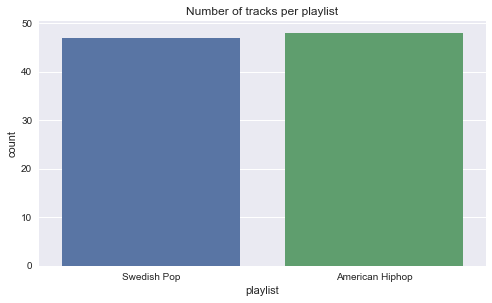

In [63]:
f, ax = plt.subplots(figsize=(8,4.5))

sns.countplot(x='playlist', data=track_feature_df, ax=ax)
ax.set_title('Number of tracks per playlist')

## Null values

In [64]:
df = track_feature_df.isnull().sum().sort_values(ascending=False)
df[df>0]

Series([], dtype: int64)

No null values!

## Columns

The columns available for each track are:
* **Album**, what album the track appears on
* **Artists,** a list of the artists of the track
* **Name,** the name of the track
* **Playlist,** what playlist I fetched the track from
* **Acousticness,** "A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic."
* **Danceability,** "Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable."
* **Duration** (ms), "The duration of the track in milliseconds."
* **Energy,** "	Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy."
* **Instrumentalness,** "Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0."
* **Key,** "The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on."
* **Liveness,** "Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live."
* **Loudness,** "The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db."
* **Mode,** "Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0."
* **Speechiness,** "Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks."
* **Tempo,** "The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration."
* **Time** Signature, "An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure)."
* **Valence,** "A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)."

I could probably achieve a clustering similar to the two playlist groups by determining the language of the artists or album assiciated with each track. However, this is not what I am interested in doing, as I am much more ineterested in the musical features.

In [65]:
track_feature_df.head(1)

,album,artists,name,playlist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,uri,valence
0,Snart Skiner Poseidon,[Joel Alme],Snart Skiner Poseidon,Swedish Pop,0.828,0.253,178978,0.482,0.000004,2,0.153,-5.22,1,0.0306,140.507,3,spotify:track:2eljaMe4nUwA2vqdzVV8FX,0.349


### Quantitative features 
I will start of by examining quantitative features. I will normalise the ones not in the range 0..1.

In [66]:
quantitative_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence', 'loudness', 'tempo', 'duration_ms']

In [67]:
def minmax_scale(vec):
    max_val = vec.max()
    min_val = vec.min()
    
    return (vec - min_val) / (max_val - min_val)

In [68]:
normalised_df = track_feature_df.copy()
normalised_df['tempo'] = minmax_scale(normalised_df['tempo'])
normalised_df['loudness'] = minmax_scale(normalised_df['loudness'])
normalised_df['duration_ms'] = minmax_scale(normalised_df['duration_ms'])

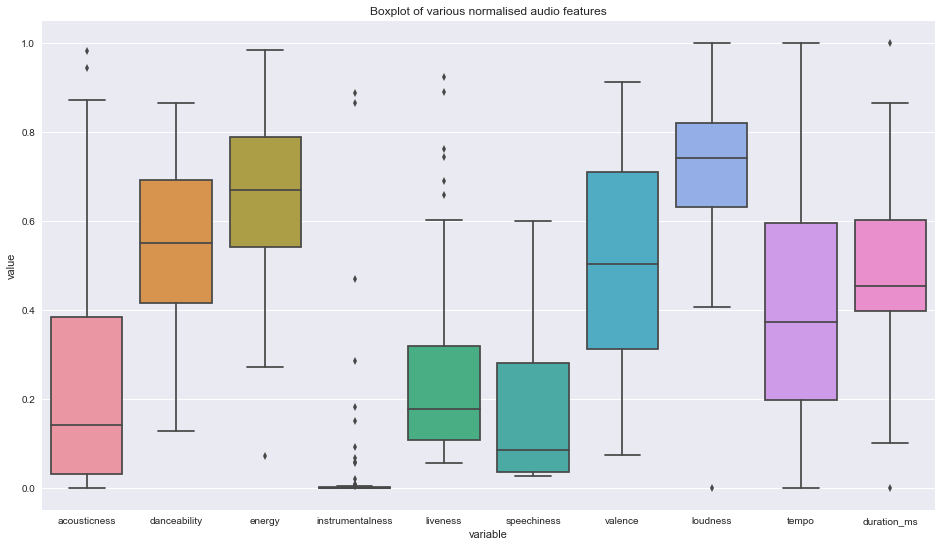

In [69]:
df = normalised_df.melt(value_vars=quantitative_features)

f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x = 'variable', y='value', data = df, ax=ax)
ax.set_title('Boxplot of various normalised audio features')

The features fall in quite different ranges. This is something I will have to take in to account when doing clustering later.  I should porbably normalise all the features, not only the ones with values outside [0..1].

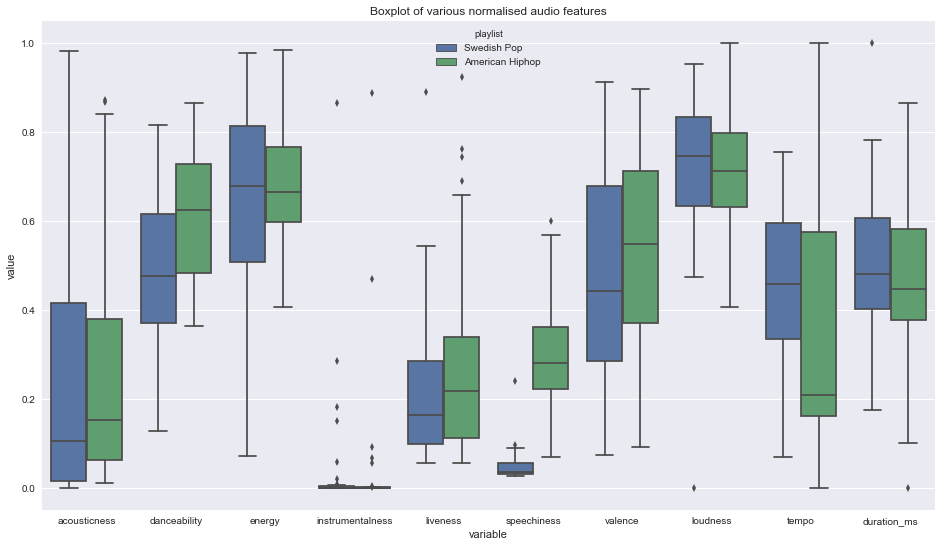

In [70]:
df = normalised_df.melt(id_vars = 'playlist', value_vars=quantitative_features)

f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x = 'variable', y='value', hue = 'playlist', data = df, ax=ax)
ax.set_title('Boxplot of various normalised audio features')

Most features overlap significantly between the two playlists! The one clear exception is `speechiness` which is a clear indicator of the track belonging to the Hiphop playlist.

### Categorical Features
Let's have a look at the categorical features now.
I will treat `key` and `timesignature` as categoricals instead of ordinals, even though they have a clear internal ordering. 
My reason for this is that I do not see these orders as meaningfull in categorizing the tracks.
A track in the key `G` is not "more" than a track in `C`, and a track with time signature `3/4` is not more than a track with time signature `5/4` (These tracks would receive time signatures 3 and 5 respectively). 

First lets relabel the keys and mode to human readable format.

In [71]:
categorical_features = ['mode', 'key', 'time_signature']

In [72]:
key_vec = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#', 'A', 'Bb', 'B']
track_feature_df['key'] = track_feature_df['key'].apply(lambda x: key_vec[x])

mode_vec = ['Minor', 'Major']
track_feature_df['mode'] = track_feature_df['mode'].apply(lambda x: mode_vec[x])

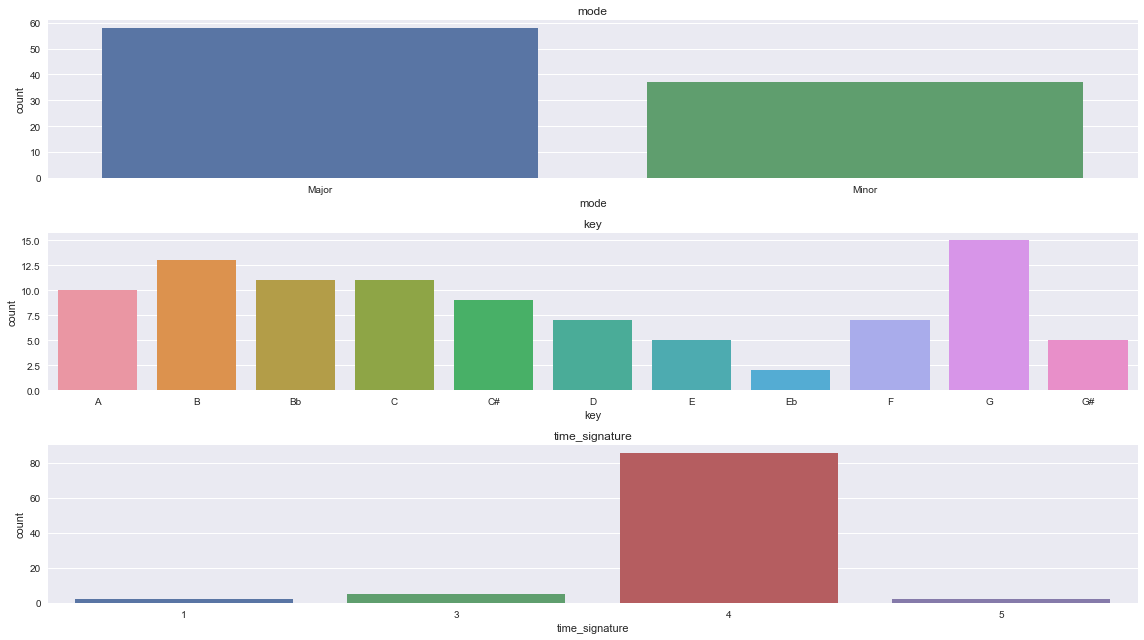

In [73]:
f, ax = plt.subplots(len(categorical_features), 1, figsize=(16,9))

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, data=track_feature_df, ax=ax[i], order = sorted(track_feature_df[col].unique()))
    ax[i].set_title(col)
f.tight_layout()

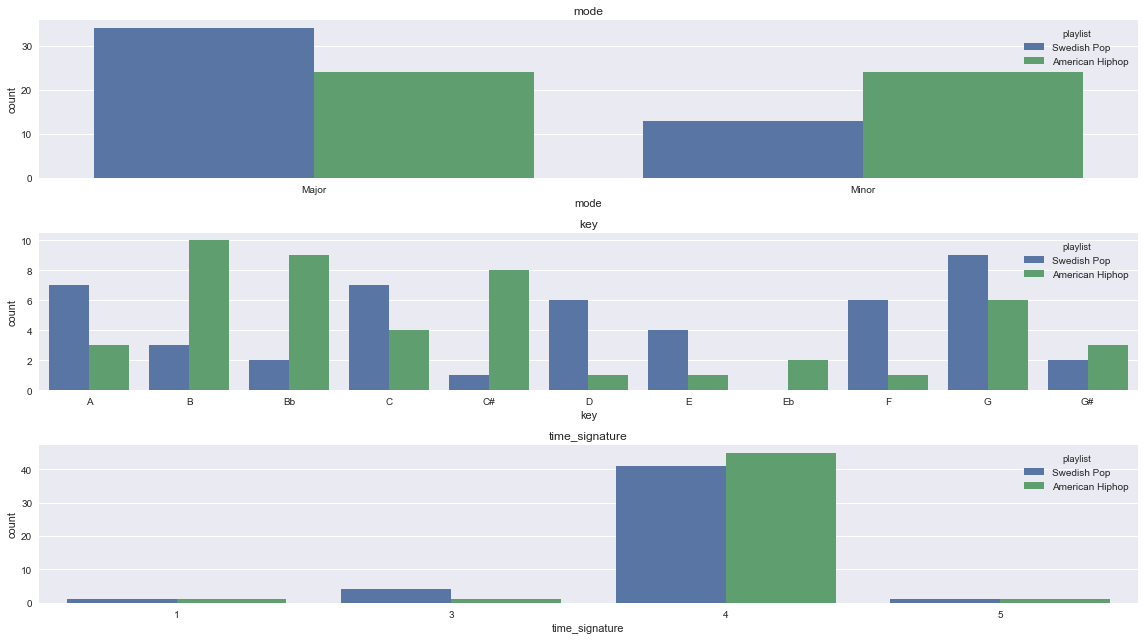

In [74]:
f, ax = plt.subplots(len(categorical_features), 1, figsize=(16,9))

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue='playlist', data=track_feature_df, ax=ax[i], order = sorted(track_feature_df[col].unique()))
    ax[i].set_title(col)
f.tight_layout()

4 beats per bar is definitely the most common. 

Both playlists have a similar distribution of tracks in Major and Minor key.

What is most interesting is how some keys are much more prevelant in one list compared to the other. For example, C is the most common key in the pop playlist, while it is not so common in the Hiphop playlist. For G we see the exact opposite case.

## Feature Correlation
Let's see if we can find some pairwise correlations among the features.

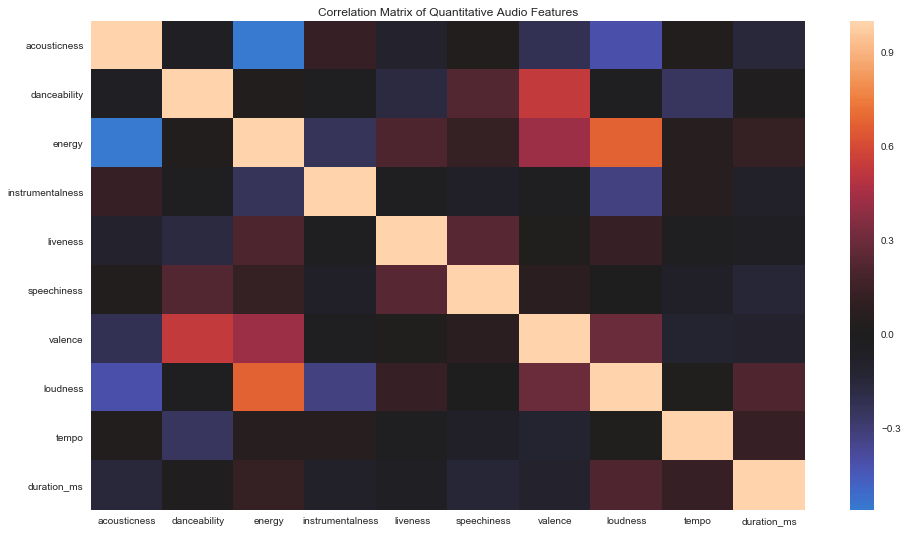

In [75]:
f, ax = plt.subplots(figsize=(16,9))
sns.heatmap(track_feature_df[quantitative_features].corr(), ax = ax, center = 0)
ax.set_title('Correlation Matrix of Quantitative Audio Features')

Many features seem to be uncorrelated, but there are some worthy mentions. Let's print out all pairs with an absolute correlation value > 0.3.

In [76]:
import itertools

corr_mat = track_feature_df[quantitative_features].corr().reset_index()
correlatin_pairs = []
col_set = set()
for i, col in enumerate(corr_mat.columns[1:-1]):
    # Only check the bottom triangle in the matrix, ignore the diagonal.
    df = corr_mat.loc[i+1: ,['index', col]]
    df = df[df[col].apply(lambda x: abs(x) > .3)]
    correlatin_pairs += zip(df['index'], itertools.repeat(col), df[col])
    for val in df['index'].values:
        col_set.add(val)
    col_set.add(col)
    

In [77]:
correlatin_pairs = sorted(correlatin_pairs, key=lambda x: (x[2]))

In [78]:
correlatin_pairs

[('energy', 'acousticness', -0.55982915851616211),
 ('loudness', 'acousticness', -0.41250397427456359),
 ('loudness', 'instrumentalness', -0.32590010497886013),
 ('valence', 'energy', 0.42263051869623319),
 ('valence', 'danceability', 0.53276763612800571),
 ('loudness', 'energy', 0.67216460070753181)]

**Energy and Acousticness**, clear negative correlation.<br> I think this is expected.<br><br>
**Loudness and Acousticness**, negative correlation.<br> I think this is expected.<br><br>
**Instrumentalness and Loudness**, somewhat negative correlation.<br> Also somewhat expected, at least given the context that these lists do not contain any loud instrumental genres like hardstyle etc.<br><br>
**Danceability and Valence**, clear positive ocrrelation.<br> I think this is expected.<br><br>
**Energy and Valence**, clear positive ocrrelation.<br> I think this is expected.<br><br>
**Energy and Loudness**, clear positive ocrrelation.<br> I think this is expected.


Let's plot the relevant scatterplots.

In [79]:
len(correlatin_pairs)

6

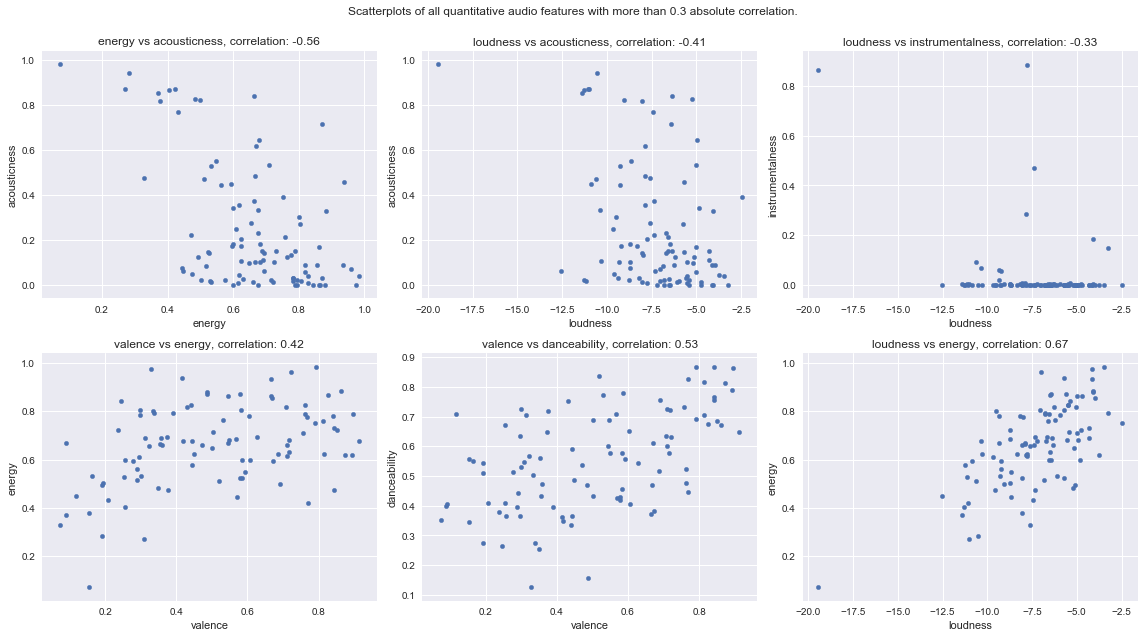

In [80]:
f, ax = plt.subplots(2, 3, figsize=(16,9))
ax = ax.flatten()

for i, (col1, col2, corr) in enumerate(correlatin_pairs):
    track_feature_df.plot.scatter(x = col1, y=col2, ax= ax[i])
    ax[i].set_xlabel(col1)
    ax[i].set_ylabel(col2)
    ax[i].set_title("{} vs {}, correlation: {}".format(col1, col2, round(corr, 2)))
f.tight_layout(rect=[0, 0, 1 ,.95])
f.suptitle("Scatterplots of all quantitative audio features with more than 0.3 absolute correlation.")

Right, almost no tracks are instrumental so it's not really interesting to look at that feature.

Correlation for Loudness vs Acoustic also looks like bogus, as it seems heavily influenced by an outlier in the top left corner.

The correlations for the most correlated pairs look valid though, but I don't think it's large enough to consider any of the features redundant.

# Summary
I have used Spotify's Web API to fetch audio fatures and some meta data for 95 tracks from two of my Daily mixes, one with American hiphop and one with Swedish pop.
I have quickly explored the feature values and their correlation.

I noticed that the quantitative features fall in quite different ranges withing [0..1], which is something I must take in to account when doing clustering.

## Store the data

In [81]:
track_feature_df.to_pickle('track_audio_features.pkl')